# Homework 4 - Getting to know your customers

## 1. Finding Similar Costumers

Companies nowadays are implementing product suggestions to provide users with things they are likely to buy. The process often starts by finding similar behaviours among consumers; for this task, we will focus on this part in the specific.
Here you will implement an algorithm to find the most similar match to a consumer given his bank account information. In particular, you will implement your version of the LSH algorithm that takes as input information about a consumer and finds people similar to the one in the study.

## 1.1 Set up the data

For the sake of this first part, not all columns are necessary since comparing each field single handedly can be quite time-expensive. Then, carefully read the linked guide above and try to understand which features will be appropriate for this task (An heads up: some users have more than one transaction record, make sure to handle them all). Once you have finished, project a version of the dataset to work with.


First of all we use pandas to import the dataset of transaction of a bank in India. The features that could be useful to match similar consumer given the bank accont information are: CustomerID, CustomerDOB (to group by similar ages), CustGender, CustAccountBalance (to group by richness) and TransactionAmount (to group by how much money they use). We are not interested in location (all are in India) and the time of the transaction, but we'll keep transaction date to calculate the age of the person at the year in which the data are taken.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm as tq
from math import sqrt
import seaborn as sn
from statistics import mean
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/Users/giacomo/Desktop/locale/bank_transactions.csv', usecols = ['TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender', 'TransactionDate', 'CustAccountBalance', 'TransactionAmount (INR)'])

In [3]:
df.copy()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionDate,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,17819.05,2/8/16,25.0
1,T2,C2142763,4/4/57,M,2270.69,2/8/16,27999.0
2,T3,C4417068,26/11/96,F,17874.44,2/8/16,459.0
3,T4,C5342380,14/9/73,F,866503.21,2/8/16,2060.0
4,T5,C9031234,24/3/88,F,6714.43,2/8/16,1762.5
...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,8/4/90,M,7635.19,18/9/16,799.0
1048563,T1048564,C6459278,20/2/92,M,27311.42,18/9/16,460.0
1048564,T1048565,C6412354,18/5/89,M,221757.06,18/9/16,770.0
1048565,T1048566,C6420483,30/8/78,M,10117.87,18/9/16,1000.0


The dataset is composed by 1048567 transactions and 7 features referred to: TransactionID, CustomerID	CustomerDOB, CustGender, CustAccountBalance, TransactionDate, TransactionAmount (INR). Let's have a look into the missing values:

In [4]:
df.isna().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustAccountBalance         2369
TransactionDate               0
TransactionAmount (INR)       0
dtype: int64

Given that the dataset is composed by 1048567 rows the missing values are a small percentage, so we decide to drop them: 

In [5]:
df = df.dropna()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1041765 entries, 0 to 1048566
Data columns (total 7 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1041765 non-null  object 
 1   CustomerID               1041765 non-null  object 
 2   CustomerDOB              1041765 non-null  object 
 3   CustGender               1041765 non-null  object 
 4   CustAccountBalance       1041765 non-null  float64
 5   TransactionDate          1041765 non-null  object 
 6   TransactionAmount (INR)  1041765 non-null  float64
dtypes: float64(2), object(5)
memory usage: 63.6+ MB


# 1.1.1 Cust Gender

We started exploring the Gender of the customers:

In [7]:
type(df['CustGender'][0])

str

In [8]:
df['CustGender'].value_counts()

M    761098
F    280666
T         1
Name: CustGender, dtype: int64

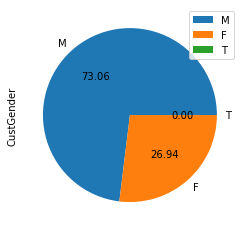

In [9]:
df['CustGender'].value_counts().plot(kind='pie', autopct='%.2f')

plt.legend()
 
plt.show()

We noticed that there is a 'T' classified gender in the dataset: 

In [9]:
df[df["CustGender"] == 'T'] 

,TransactionID,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionDate,TransactionAmount (INR)
959987,T959988,C3380368,1/1/1800,T,50050.0,10/9/16,32500.0


In [10]:
df[df['CustomerID'] == 'C3380368'] 

,TransactionID,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionDate,TransactionAmount (INR)
959987,T959988,C3380368,1/1/1800,T,50050.0,10/9/16,32500.0


Given that we have 1041614 transaction and there is only one transaction referred to this Customer ID we decided to drop it: 

In [11]:
df.drop(df[df.CustGender == 'T'].index, axis=0, inplace=True)

Then we decided to rearrange CustGender column with 0/1 values (female/male):

In [12]:
df['CustGender'] = df.CustGender.apply(lambda x: 1 if x == 'M' else 0)

In [13]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionDate,TransactionAmount (INR)
0,T1,C5841053,10/1/94,0,17819.05,2/8/16,25.0
1,T2,C2142763,4/4/57,1,2270.69,2/8/16,27999.0
2,T3,C4417068,26/11/96,0,17874.44,2/8/16,459.0
3,T4,C5342380,14/9/73,0,866503.21,2/8/16,2060.0
4,T5,C9031234,24/3/88,0,6714.43,2/8/16,1762.5


# 1.1.2 Age

We decided to convert into datetime the date of birthday of the customers and the date of the transaction:

In [14]:
print(type(df['CustomerDOB'][0]), type(df['TransactionDate'][0]))

<class 'str'> <class 'str'>


In [15]:
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'])

df['TransactionDate'] = pd.to_datetime(df['TransactionDate']) 

In [16]:
df.head(1)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionDate,TransactionAmount (INR)
0,T1,C5841053,1994-10-01,0,17819.05,2016-02-08,25.0


In [17]:
df['TransactionDate'].dt.year.value_counts()

2016    1041764
Name: TransactionDate, dtype: int64

In [18]:
df['TransactionDate'].dt.month.value_counts()

8     427368
9     157939
10     50742
7      48092
11     47036
4      46963
3      46755
6      45935
2      43510
12     42892
1      42460
5      42072
Name: TransactionDate, dtype: int64

All the data were taken in 2016, so we'll use this year to calculate the ages.
Going through the Date of Birthday we can see that there is something strange: there are dates of birthday referred to 1800, probably cause it is a default value when this data is missing, and a right tail that seems to be a part of the main figure with an offset: 

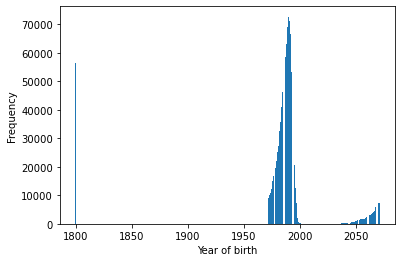

In [19]:
count = Counter(df['CustomerDOB'].dt.year)

plt.bar(count.keys(), count.values())

plt.xlabel('Year of birth')

plt.ylabel('Frequency')
 
plt.show()

In [20]:
df.loc[df['CustomerDOB'].dt.year == 1800]['CustomerDOB'].value_counts()

1800-01-01    56291
Name: CustomerDOB, dtype: int64

We decided to replace DOB referred to year 1800 with 0 values and rearrange the data after year 2000 adjusting the offset. The NaN values will not be a problem cause they will have only zero in the 'bolean' matrix referred to the ages. 

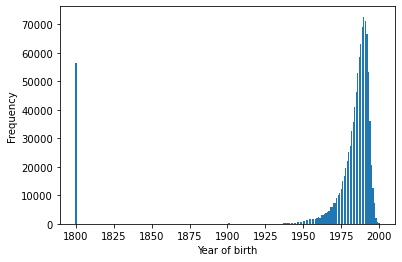

In [21]:
df.loc[df.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = df.loc[df.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

count = Counter(df['CustomerDOB'].dt.year)

plt.bar(count.keys(), count.values())

plt.xlabel('Year of birth')

plt.ylabel('Frequency')
 
plt.show()

We created a 'CustomerAge' column filling it with 0 values:

In [22]:
df['CustomerAge'] = 0

Then we substitute ages that have YOB different from 1800:

In [23]:
df.loc[df['CustomerDOB'].dt.year != 1800, 'CustomerAge'] = df.loc[df['CustomerDOB'].dt.year != 1800, 'TransactionDate'].dt.year - df.loc[df['CustomerDOB'].dt.year != 1800, 'CustomerDOB'].dt.year 

In [24]:
df['CustomerAge'] = df['CustomerAge'].astype(int)

In [25]:
del df['TransactionDate']

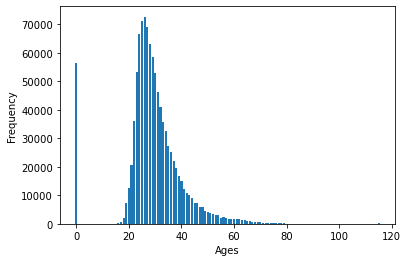

In [26]:
count = Counter(df['CustomerAge'])

plt.bar(count.keys(), count.values())

plt.xlabel('Ages')

plt.ylabel('Frequency')

plt.show()

Exploring the ages at the edges we can see that: 

In [27]:
df.loc[df['CustomerAge'] != 0]['CustomerAge'].min()

16

In [28]:
df['CustomerAge'].max()

115

Considering that the oldest person ever in India was Lucy d'Abreu who lived 113 years and 197 days (ref: Wikipedia) it seems a good choice to drop all the ages over 100 years.

In [29]:
df.drop(df[df.CustomerAge > 100].index, axis=0, inplace=True)

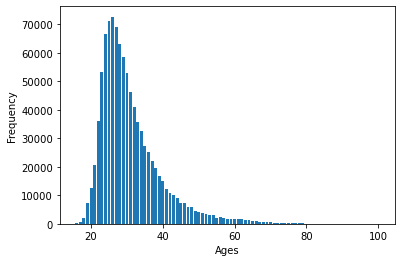

In [30]:
count = Counter(df['CustomerAge'])

count.pop(0, None)

plt.bar(count.keys(), count.values())

plt.xlabel('Ages')

plt.ylabel('Frequency')

plt.show()

In order to implement a Minhash function we decide to divide the CustomAge data in class of ages. Similar ages should led to similar interest. For this reason, looking at the distribution of ages and using our intuition, it seems to be a good choice to divide in: 

 - Age_1 --> 16 $\leq$ Age $\leq$ 25
 
 - Age_2 --> 26 $\leq$ Age $\leq$ 35
 
 - Age_3 --> 36 $\leq$ Age $\leq$ 45
 
 - Age_4 --> 46 $\leq$ Age $\leq$ 65
 
 - Age_5 --> 66 $\leq$ Age $\leq$ 85
 
 - Age_5 --> 86 $\leq$ Age $\leq$ 100

In [31]:
bins = np.array([16, 26, 36, 46, 66, 85, 101])

def age(age):
    
    class_age = np.digitize(age, bins, right=False)  #return the number of the bin
    
    age = 'age_' + str(class_age)
        
    return age

In [32]:
df['CustomerClassAge'] = df.CustomerAge.apply(lambda x: age(x))

In [33]:
df

,TransactionID,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge,CustomerClassAge
0,T1,C5841053,1994-10-01,0,17819.05,25.0,22,age_1
1,T2,C2142763,1957-04-04,1,2270.69,27999.0,59,age_4
2,T3,C4417068,1996-11-26,0,17874.44,459.0,20,age_1
3,T4,C5342380,1973-09-14,0,866503.21,2060.0,43,age_3
4,T5,C9031234,1988-03-24,0,6714.43,1762.5,28,age_2
...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,1990-08-04,1,7635.19,799.0,26,age_2
1048563,T1048564,C6459278,1992-02-20,1,27311.42,460.0,24,age_1
1048564,T1048565,C6412354,1989-05-18,1,221757.06,770.0,27,age_2
1048565,T1048566,C6420483,1978-08-30,1,10117.87,1000.0,38,age_3


Customer with age 0 are classified as 'CustomerClassAge' 0: 

In [34]:
df.loc[df['CustomerAge'] == 0]

,TransactionID,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge,CustomerClassAge
16,T17,C1376215,1800-01-01,1,77495.15,1423.11,0,age_0
22,T23,C7018081,1800-01-01,1,143.07,110.00,0,age_0
28,T29,C7935438,1800-01-01,1,969436.12,36.90,0,age_0
35,T36,C1211387,1800-01-01,1,11791.25,1075.00,0,age_0
151,T152,C3334638,1800-01-01,1,700.00,1500.00,0,age_0
...,...,...,...,...,...,...,...,...
1048443,T1048444,C7261226,1800-01-01,1,1393.33,200.00,0,age_0
1048452,T1048453,C3813481,1800-01-01,1,984605.24,219.00,0,age_0
1048531,T1048532,C6937679,1800-01-01,1,50698.90,598.86,0,age_0
1048533,T1048534,C7431884,1800-01-01,1,53771.64,520.00,0,age_0


Age_0 will not be insterted into shingles, such that the one hot vector referred to a missing value of age will have only zeros.

# 1.1.3 Different people with the same CustomerID

We decided to check the data related to transactions referred to the same CustomerID:

In [35]:
a = df.groupby('CustomerID').TransactionID.count()  #series with number of transaction per CustomerID

df[df.CustomerID.isin(a[a>1].index)].sort_values(by="CustomerID") #same customer with more than one transaction

,TransactionID,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge,CustomerClassAge
33670,T33671,C1010011,1992-08-19,0,32500.73,4750.00,24,age_1
173508,T173509,C1010011,1983-05-08,1,120180.54,356.00,33,age_2
251647,T251648,C1010014,1984-08-19,1,161848.76,250.00,32,age_2
89543,T89544,C1010014,1992-04-06,0,38377.14,1205.00,24,age_1
50880,T50881,C1010031,1984-07-21,1,1754.10,404.00,32,age_2
...,...,...,...,...,...,...,...,...
407803,T407804,C9094224,1980-06-24,0,10579.38,2458.00,36,age_3
673478,T673479,C9095886,1992-06-04,1,284.48,123.89,24,age_1
500536,T500537,C9095886,1991-06-19,0,27313.55,289.37,25,age_1
545604,T545605,C9096252,1991-04-03,1,9424.29,50.00,25,age_1


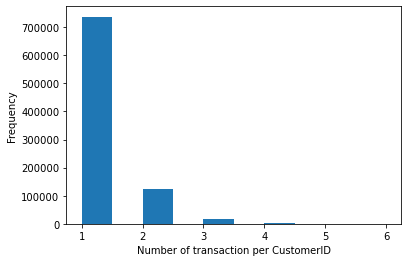

In [36]:
df.groupby('CustomerID').TransactionID.count().plot.hist()

plt.xlabel('Number of transaction per CustomerID')

plt.ylabel('Frequency')

plt.show()

We can see that transactions addressed to the same CustomerID are instead related to different people but labeled with the same username. We can say that with high probability these kind of CustomerID are referred to a family or in general groups of people. However, if we wanna group by similar transactions this is not a problem for us.

# 1.1.4 Same people with different CustomerID

We decided to check if there could be person labelled with different CustomerID but that have many information in common:

In [37]:
df.loc[df['CustomerDOB'].dt.year != 1800].sort_values(by = ['CustomerDOB', 'CustAccountBalance', 'CustGender'], ascending = True)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge,CustomerClassAge
114611,T114612,C2846955,1916-02-22,1,16205.90,460.00,100,age_6
128470,T128471,C6946973,1916-02-22,1,16205.90,294.00,100,age_6
914000,T914001,C2638825,1918-03-05,0,11725.34,250.00,98,age_6
26154,T26155,C4925544,1919-12-15,0,27081.15,12580.29,97,age_6
170160,T170161,C7625552,1919-12-15,0,27081.15,500.00,97,age_6
...,...,...,...,...,...,...,...,...
650778,T650779,C7920950,2000-12-20,1,8774.87,195.00,16,age_1
977850,T977851,C1520914,2000-12-20,1,8774.87,4721.00,16,age_1
1011847,T1011848,C1228222,2000-12-21,0,7077.98,4275.00,16,age_1
1015853,T1015854,C5528253,2000-12-21,0,7077.98,2285.00,16,age_1


We can see that there are people who are labelled with different CustomerID but have all the other fields identical. So we can say that, with high probability, they are the same person. We could hypothesize that anytime a person do a different transaction is saved with a different CustomerID, but we do not have enough information to make this assumption. So, we'll threat them as different people. However, this could not be an error in order to implement LSH algorithm: for example, if we group by similar ages, total balance, they will go with high probability to the same bucket (they are different only for the 'TransactionAmount (INR)' value). 

If we group by similar transaction data we do not need the 'CustomerID' column: 

In [38]:
del df['CustomerID'], df['CustomerDOB']

# 1.1.5 Customer Account Balance

In [39]:
type(df['CustAccountBalance'][0])

numpy.float64

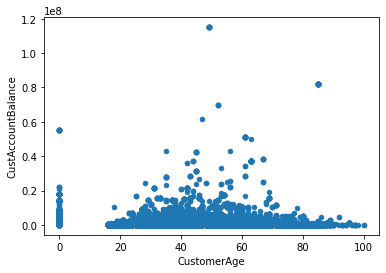

In [40]:
df[['CustAccountBalance', 'CustomerAge']].plot(kind = 'scatter', x= 'CustomerAge', y = 'CustAccountBalance')

plt.show()

We decided to binning the CustAccountBalance through the qcut function: "The pandas documentation describes qcut as a “Quantile-based discretization function.” This basically means that qcut tries to divide up the underlying data into equal sized bins. The function defines the bins using percentiles based on the distribution of the data, not the actual numeric edges of the bins. "

In [41]:
df['CustAccountBalance'].describe()

count    1.041144e+06
mean     1.150362e+05
std      8.469470e+05
min      0.000000e+00
25%      4.729190e+03
50%      1.677460e+04
75%      5.745586e+04
max      1.150355e+08
Name: CustAccountBalance, dtype: float64

In [42]:
df['CustAccountBalance'].value_counts().sort_index()

0.000000e+00    2609
1.000000e-02     300
2.000000e-02      79
3.000000e-02      44
4.000000e-02      86
                ... 
5.536969e+07      12
6.138221e+07       1
6.979933e+07       4
8.224463e+07      19
1.150355e+08      10
Name: CustAccountBalance, Length: 160573, dtype: int64

We decide to label people with 10 classes of richness, from 1 to 10. We choose to turn into class 0 of richness transaction with CustAccountBalance < 1. In fact these values could be missing values (in the 0 case) or accounts that are not more active:

In [45]:
bin_labels = ['richness_1', 'richness_2', 'richness_3', 'richness_4', 'richness_5', 'richness_6', 'richness_7', 'richness_8', 'richness_9', 'richness_10']

In [46]:
df['Richness'] = pd.qcut(df['CustAccountBalance'], q = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1], labels = bin_labels)

In [47]:
df.sort_values(by = 'CustAccountBalance', ascending = True)

,TransactionID,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge,CustomerClassAge,Richness
339528,T339529,0,0.0,200.0,30,age_2,richness_1
416346,T416347,1,0.0,507.0,0,age_0,richness_1
1000014,T1000015,0,0.0,1800.0,53,age_4,richness_1
28851,T28852,1,0.0,500.0,32,age_2,richness_1
648525,T648526,1,0.0,1087.0,54,age_4,richness_1
...,...,...,...,...,...,...,...
1001213,T1001214,1,115035495.1,1599.0,49,age_4,richness_10
835641,T835642,1,115035495.1,600.0,49,age_4,richness_10
1002072,T1002073,1,115035495.1,5060.0,49,age_4,richness_10
826721,T826722,1,115035495.1,4699.0,49,age_4,richness_10


In [48]:
del df['CustAccountBalance']

# 1.1.6 Transaction Amount (INR)

In [49]:
type(df['TransactionAmount (INR)'][0])

numpy.float64

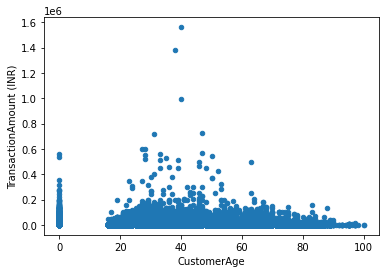

In [50]:
df[['TransactionAmount (INR)', 'CustomerAge']].plot(kind = 'scatter', x= 'CustomerAge', y = 'TransactionAmount (INR)')

plt.show()

In [51]:
df['TransactionAmount (INR)'].describe()

count    1.041144e+06
mean     1.565763e+03
std      6.562031e+03
min      0.000000e+00
25%      1.600000e+02
50%      4.570000e+02
75%      1.200000e+03
max      1.560035e+06
Name: TransactionAmount (INR), dtype: float64

In [52]:
bin_labels = ['exp_1', 'exp_2', 'exp_3', 'exp_4', 'exp_5', 'exp_6', 'exp_7', 'exp_8', 'exp_9', 'exp_10']

We decided to threat this values in the same way of the previous point: 

In [53]:
df['Expenditure'] = pd.qcut(df['TransactionAmount (INR)'], q = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1], labels = bin_labels)

In [54]:
df.head()

,TransactionID,CustGender,TransactionAmount (INR),CustomerAge,CustomerClassAge,Richness,Expenditure
0,T1,0,25.0,22,age_1,richness_6,exp_1
1,T2,1,27999.0,59,age_4,richness_2,exp_10
2,T3,0,459.0,20,age_1,richness_6,exp_6
3,T4,0,2060.0,43,age_3,richness_10,exp_9
4,T5,0,1762.5,28,age_2,richness_4,exp_9


In [55]:
del df['TransactionAmount (INR)'], df['CustomerAge']

# 1.1.7 Final Dataset

The final result is showed below:

In [56]:
df = df.reset_index(drop = True)
df

,TransactionID,CustGender,CustomerClassAge,Richness,Expenditure
0,T1,0,age_1,richness_6,exp_1
1,T2,1,age_4,richness_2,exp_10
2,T3,0,age_1,richness_6,exp_6
3,T4,0,age_3,richness_10,exp_9
4,T5,0,age_2,richness_4,exp_9
...,...,...,...,...,...
1041139,T1048563,1,age_2,richness_4,exp_7
1041140,T1048564,1,age_1,richness_7,exp_6
1041141,T1048565,1,age_2,richness_10,exp_7
1041142,T1048566,1,age_3,richness_4,exp_7


In [57]:
df.to_csv('/Users/giacomo/Desktop/locale/data.csv', sep = '\t')